In [1]:
"""
Configuração do ambiente de execução.

Garante que as versões das dependências críticas estejam disponíveis
e documenta o ambiente para reprodutibilidade. No Google Colab, as
bibliotecas abaixo já vêm pré-instaladas; esta célula serve como
checagem defensiva e registro de versões.
"""

import sys
import importlib

DEPENDENCIAS_REQUERIDAS = [
    "pandas",
    "numpy",
    "sklearn",
    "matplotlib",
    "seaborn",
]

print(f"Python {sys.version}\n")

for pacote in DEPENDENCIAS_REQUERIDAS:
    try:
        mod = importlib.import_module(pacote)
        versao = getattr(mod, "__version__", "versão não disponível")
        print(f"  ✔ {pacote:.<20s} {versao}")
    except ImportError as erro:
        print(f"  ✘ {pacote:.<20s} NÃO ENCONTRADO — {erro}")

print("\nAmbiente verificado com sucesso.")

Python 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]

  ✔ pandas.............. 2.2.2
  ✔ numpy............... 2.0.2
  ✔ sklearn............. 1.6.1
  ✔ matplotlib.......... 3.10.0
  ✔ seaborn............. 0.13.2

Ambiente verificado com sucesso.


In [2]:
"""
Imports centralizados para todo o notebook.

Estratégia: concentrar todos os imports em uma única célula facilita a
manutenção, evita imports duplicados e permite identificar rapidamente
as dependências do projeto. Os alias seguem as convenções da comunidade
Python científica (np, pd, plt, sns).

Organização por responsabilidade:
  1. Manipulação de dados
  2. Visualização
  3. Pré-processamento (Scikit-learn)
  4. Modelos
  5. Métricas de avaliação
  6. Utilitários
"""

# --- 1. Manipulação de dados ---
import numpy as np
import pandas as pd

# --- 2. Visualização ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- 3. Pré-processamento ---
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (
    LabelEncoder,
    MinMaxScaler,
    StandardScaler,
)

# --- 4. Modelos ---
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# --- 5. Métricas ---
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    roc_auc_score,
    roc_curve,
)

# --- 6. Utilitários ---
import warnings

warnings.filterwarnings("ignore")

# Configuração global de visualização para consistência entre gráficos
sns.set_theme(style="whitegrid", palette="muted", font_scale=1.1)
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 12

print("Imports carregados com sucesso.")

Imports carregados com sucesso.


In [6]:
"""
Carregamento do dataset tratado na Parte 1 e verificação de integridade.

Checklist de integridade executado automaticamente:
  - Shape (linhas × colunas)
  - Tipos de dados por coluna
  - Contagem de valores nulos residuais
  - Distribuição da variável-alvo (cancelou) para detectar desbalanceamento

Se houver nulos residuais ou a coluna-alvo não existir, o código emite
alertas claros para facilitar o debug antes de prosseguir.
"""

CAMINHO_DADOS = "/content/dados_tratados.csv"

df = pd.read_csv(CAMINHO_DADOS)

# --- Verificação dimensional ---
print("=" * 60)
print(f"  Dataset carregado: {df.shape[0]:,} linhas × {df.shape[1]} colunas")
print("=" * 60)

# --- Tipos de dados ---
print("\n📋 Tipos de dados por coluna:\n")
print(df.dtypes.to_string())

# --- Valores nulos ---
nulos = df.isnull().sum()
total_nulos = nulos.sum()

if total_nulos == 0:
    print(f"\n✔ Nenhum valor nulo encontrado.")
else:
    print(f"\n⚠ {total_nulos} valores nulos detectados:")
    print(nulos[nulos > 0].to_string())

# --- Variável-alvo ---
COLUNA_ALVO = "cancelou"

if COLUNA_ALVO in df.columns:
    print(f"\n📊 Distribuição da variável-alvo '{COLUNA_ALVO}':\n")
    distribuicao = df[COLUNA_ALVO].value_counts()
    distribuicao_pct = df[COLUNA_ALVO].value_counts(normalize=True) * 100

    for valor in distribuicao.index:
        print(
            f"  {valor}: {distribuicao[valor]:,} "
            f"({distribuicao_pct[valor]:.1f}%)"
        )

    razao = distribuicao.min() / distribuicao.max()
    if razao < 0.4:
        print(
            f"\n⚠ Classes desbalanceadas (razão minoria/maioria = {razao:.2f}). "
            "Trataremos isso na etapa de modelagem."
        )
    else:
        print(f"\n✔ Proporção entre classes aceitável (razão = {razao:.2f}).")
else:
    print(
        f"\n❌ ERRO CRÍTICO: coluna '{COLUNA_ALVO}' não encontrada. "
        "Verifique o dataset de origem."
    )

  Dataset carregado: 7,043 linhas × 21 colunas

📋 Tipos de dados por coluna:

id_cliente               object
cancelou                 object
genero                   object
idoso                     int64
tem_parceiro             object
tem_dependentes          object
meses_cliente             int64
servico_telefone         object
linhas_multiplas         object
tipo_internet            object
seguranca_online         object
backup_online            object
protecao_dispositivo     object
suporte_tecnico          object
streaming_tv             object
streaming_filmes         object
tipo_contrato            object
fatura_digital           object
metodo_pagamento         object
cobranca_mensal         float64
cobranca_total          float64

✔ Nenhum valor nulo encontrado.

📊 Distribuição da variável-alvo 'cancelou':

  No: 5,174 (73.5%)
  Yes: 1,869 (26.5%)

⚠ Classes desbalanceadas (razão minoria/maioria = 0.36). Trataremos isso na etapa de modelagem.


In [7]:
"""
Exibição das primeiras linhas para inspeção visual rápida.

Permite validar se o encoding/tratamento da Parte 1 foi preservado
corretamente após o salvamento e recarregamento do CSV.
"""

df.head()

,id_cliente,cancelou,genero,idoso,tem_parceiro,tem_dependentes,meses_cliente,servico_telefone,linhas_multiplas,tipo_internet,...,backup_online,protecao_dispositivo,suporte_tecnico,streaming_tv,streaming_filmes,tipo_contrato,fatura_digital,metodo_pagamento,cobranca_mensal,cobranca_total
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.30
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.40
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,...,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,...,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.40


In [8]:
"""
Conversão da variável-alvo 'cancelou' de categórica para numérica.

Modelos de ML do Scikit-learn exigem variáveis numéricas. A conversão
direta via mapeamento explícito é preferível ao LabelEncoder aqui por
ser mais legível e auditável — sabemos exatamente qual valor é 0 e 1.

Mapeamento:
  "No"  → 0 (cliente retido)
  "Yes" → 1 (cliente evadido / churn)
"""

df["cancelou"] = df["cancelou"].map({"No": 0, "Yes": 1})

# Validação: garante que não restaram valores não-mapeados (NaN)
nulos_alvo = df["cancelou"].isnull().sum()
if nulos_alvo > 0:
    print(f"⚠ {nulos_alvo} valores não mapeados na coluna 'cancelou'. Verifique valores únicos originais.")
else:
    print("✔ Variável-alvo convertida com sucesso:")
    print(f"  0 (retido):  {(df['cancelou'] == 0).sum():,}")
    print(f"  1 (evadido): {(df['cancelou'] == 1).sum():,}")
    print(f"  dtype: {df['cancelou'].dtype}")

✔ Variável-alvo convertida com sucesso:
  0 (retido):  5,174
  1 (evadido): 1,869
  dtype: int64


In [9]:
"""
Identificação e separação de variáveis por tipo para aplicar
transformações adequadas a cada grupo.

Lógica:
  - 'id_cliente' é removido: identificador único sem poder preditivo.
  - Variáveis numéricas: receberão normalização (StandardScaler).
  - Variáveis categóricas: receberão encoding (One-Hot).
  - 'cancelou' (alvo) é excluída de ambos os grupos — será usada
    separadamente como y na modelagem.
"""

coluna_id = "id_cliente"
coluna_alvo = "cancelou"

colunas_excluir = [coluna_id, coluna_alvo]

colunas_numericas = (
    df.select_dtypes(include=["int64", "float64"])
    .columns
    .drop(coluna_alvo, errors="ignore")
    .tolist()
)

colunas_categoricas = (
    df.select_dtypes(include=["object"])
    .columns
    .drop(coluna_id, errors="ignore")
    .tolist()
)

print(f"📐 Variáveis numéricas ({len(colunas_numericas)}):")
for col in colunas_numericas:
    print(f"  • {col} — dtype: {df[col].dtype}, únicos: {df[col].nunique()}")

print(f"\n📝 Variáveis categóricas ({len(colunas_categoricas)}):")
for col in colunas_categoricas:
    print(f"  • {col} — únicos: {df[col].nunique()} → {df[col].unique().tolist()}")

print(f"\n🚫 Excluídas: {colunas_excluir}")

📐 Variáveis numéricas (4):
  • idoso — dtype: int64, únicos: 2
  • meses_cliente — dtype: int64, únicos: 73
  • cobranca_mensal — dtype: float64, únicos: 1585
  • cobranca_total — dtype: float64, únicos: 6531

📝 Variáveis categóricas (15):
  • genero — únicos: 2 → ['Female', 'Male']
  • tem_parceiro — únicos: 2 → ['Yes', 'No']
  • tem_dependentes — únicos: 2 → ['Yes', 'No']
  • servico_telefone — únicos: 2 → ['Yes', 'No']
  • linhas_multiplas — únicos: 3 → ['No', 'Yes', 'No phone service']
  • tipo_internet — únicos: 3 → ['DSL', 'Fiber optic', 'No']
  • seguranca_online — únicos: 3 → ['No', 'Yes', 'No internet service']
  • backup_online — únicos: 3 → ['Yes', 'No', 'No internet service']
  • protecao_dispositivo — únicos: 3 → ['No', 'Yes', 'No internet service']
  • suporte_tecnico — únicos: 3 → ['Yes', 'No', 'No internet service']
  • streaming_tv — únicos: 3 → ['Yes', 'No', 'No internet service']
  • streaming_filmes — únicos: 3 → ['No', 'Yes', 'No internet service']
  • tipo_contrat

In [10]:
"""
Aplicação de One-Hot Encoding nas variáveis categóricas.

Parâmetro drop_first=True remove a primeira categoria de cada variável
para evitar multicolinearidade perfeita (armadilha da variável dummy).
Isso é especialmente importante para Regressão Linear/Logística, onde
colunas linearmente dependentes distorcem os coeficientes.

Exemplo: 'genero' com valores [Female, Male] gera apenas 'genero_Male'
  - genero_Male = 1 → masculino
  - genero_Male = 0 → feminino (implícito, é a categoria de referência)
"""

df_encoded = pd.get_dummies(
    df.drop(columns=[coluna_id]),
    columns=colunas_categoricas,
    drop_first=True,
    dtype=int,
)

print(f"✔ One-Hot Encoding aplicado.")
print(f"  Shape antes:  {df.shape[1]} colunas (incluindo id_cliente)")
print(f"  Shape depois: {df_encoded.shape[1]} colunas (sem id_cliente)")
print(f"\n📋 Novas colunas geradas:\n")

colunas_novas = [c for c in df_encoded.columns if c not in colunas_numericas + [coluna_alvo]]
for col in colunas_novas:
    print(f"  • {col}")

✔ One-Hot Encoding aplicado.
  Shape antes:  21 colunas (incluindo id_cliente)
  Shape depois: 31 colunas (sem id_cliente)

📋 Novas colunas geradas:

  • genero_Male
  • tem_parceiro_Yes
  • tem_dependentes_Yes
  • servico_telefone_Yes
  • linhas_multiplas_No phone service
  • linhas_multiplas_Yes
  • tipo_internet_Fiber optic
  • tipo_internet_No
  • seguranca_online_No internet service
  • seguranca_online_Yes
  • backup_online_No internet service
  • backup_online_Yes
  • protecao_dispositivo_No internet service
  • protecao_dispositivo_Yes
  • suporte_tecnico_No internet service
  • suporte_tecnico_Yes
  • streaming_tv_No internet service
  • streaming_tv_Yes
  • streaming_filmes_No internet service
  • streaming_filmes_Yes
  • tipo_contrato_One year
  • tipo_contrato_Two year
  • fatura_digital_Yes
  • metodo_pagamento_Credit card (automatic)
  • metodo_pagamento_Electronic check
  • metodo_pagamento_Mailed check


In [11]:
"""
Normalização (StandardScaler) das variáveis numéricas contínuas.

Justificativa: 'meses_cliente' varia de 1 a 72, 'cobranca_mensal' de
~18 a ~118, e 'cobranca_total' de ~18 a ~8.600. Sem normalização,
variáveis com maior magnitude dominariam os coeficientes de modelos
lineares, distorcendo a importância relativa de cada feature.

StandardScaler aplica: z = (x - μ) / σ
  - Resultado: média ≈ 0, desvio padrão ≈ 1 para cada variável.
  - O scaler é salvo para potencial uso em dados novos (boas práticas).
"""

scaler = StandardScaler()

df_encoded[colunas_numericas] = scaler.fit_transform(
    df_encoded[colunas_numericas]
)

print("✔ Normalização aplicada (StandardScaler).\n")
print("Estatísticas pós-normalização:")
print(df_encoded[colunas_numericas].describe().round(4).to_string())

✔ Normalização aplicada (StandardScaler).

Estatísticas pós-normalização:
           idoso  meses_cliente  cobranca_mensal  cobranca_total
count  7043.0000      7043.0000        7043.0000       7043.0000
mean     -0.0000        -0.0000          -0.0000         -0.0000
std       1.0001         1.0001           1.0001          1.0001
min      -0.4399        -1.3182          -1.5459         -1.0058
25%      -0.4399        -0.9517          -0.9725         -0.8299
50%      -0.4399        -0.1373           0.1857         -0.3905
75%      -0.4399         0.9215           0.8338          0.6648
max       2.2732         1.6137           1.7944          2.8258


In [12]:
"""
Análise de correlação entre todas as features e a variável-alvo.

Utilizamos a correlação de Pearson, que mede relações lineares entre
variáveis. Para variáveis binárias (pós-encoding), Pearson é equivalente
à correlação ponto-bisserial, sendo válido e interpretável.

O mapa de calor completo seria ilegível com 30+ colunas. Por isso:
  1. Primeiro: ranking das Top 15 features mais correlacionadas com churn.
  2. Segundo: mapa de calor focado nessas Top 15 entre si.

Interpretação:
  - Valores próximos de +1: quanto maior a feature, maior o churn.
  - Valores próximos de -1: quanto maior a feature, menor o churn.
  - Valores próximos de 0: sem relação linear com churn.
"""

correlacao_alvo = (
    df_encoded.corr()[[coluna_alvo]]
    .drop(index=coluna_alvo)
    .rename(columns={coluna_alvo: "correlacao"})
    .assign(abs_corr=lambda x: x["correlacao"].abs())
    .sort_values("abs_corr", ascending=False)
)

top_n = 15
top_features = correlacao_alvo.head(top_n)

print(f"🔍 Top {top_n} variáveis mais correlacionadas com '{coluna_alvo}':\n")
for i, (feat, row) in enumerate(top_features.iterrows(), 1):
    direcao = "↑ churn" if row["correlacao"] > 0 else "↓ churn"
    barra = "█" * int(abs(row["correlacao"]) * 40)
    print(f"  {i:2d}. {feat:<40s} {row['correlacao']:+.4f}  {direcao}  {barra}")

🔍 Top 15 variáveis mais correlacionadas com 'cancelou':

   1. meses_cliente                            -0.3522  ↓ churn  ██████████████
   2. tipo_internet_Fiber optic                +0.3080  ↑ churn  ████████████
   3. tipo_contrato_Two year                   -0.3023  ↓ churn  ████████████
   4. metodo_pagamento_Electronic check        +0.3019  ↑ churn  ████████████
   5. tipo_internet_No                         -0.2279  ↓ churn  █████████
   6. seguranca_online_No internet service     -0.2279  ↓ churn  █████████
   7. protecao_dispositivo_No internet service -0.2279  ↓ churn  █████████
   8. suporte_tecnico_No internet service      -0.2279  ↓ churn  █████████
   9. streaming_filmes_No internet service     -0.2279  ↓ churn  █████████
  10. streaming_tv_No internet service         -0.2279  ↓ churn  █████████
  11. backup_online_No internet service        -0.2279  ↓ churn  █████████
  12. cobranca_total                           -0.1983  ↓ churn  ███████
  13. cobranca_mensal          

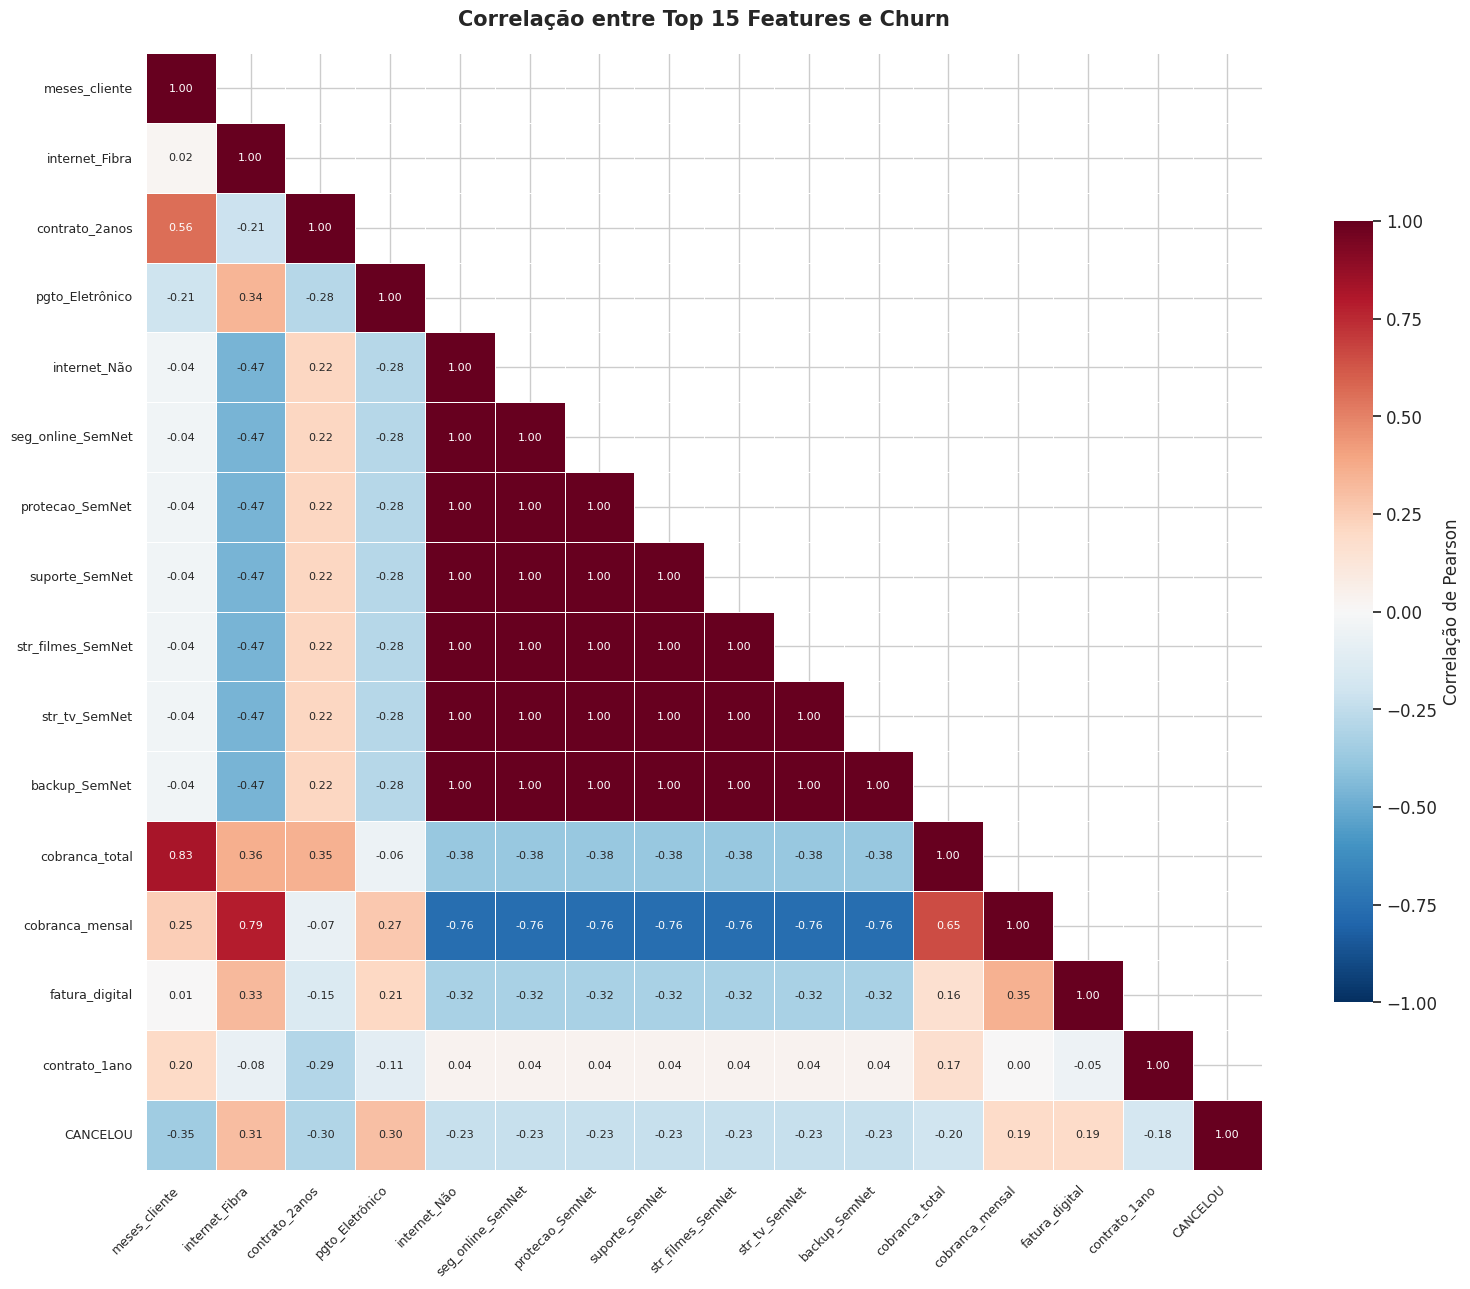


💾 Gráfico salvo em: /content/heatmap_correlacao_churn.png


In [16]:
"""
Mapa de calor da correlação entre as Top features e a variável-alvo.

Ajustes visuais aplicados:
  - Rótulos abreviados para evitar sobreposição em tela padrão do Colab.
  - Figsize ampliado e fontes reduzidas para acomodar a matriz 16×16.
  - Máscara triangular superior para evitar redundância visual.
"""

colunas_heatmap = top_features.index.tolist() + [coluna_alvo]
matriz_corr = df_encoded[colunas_heatmap].corr()

# Abreviação dos rótulos longos para legibilidade
abreviacoes = {
    "meses_cliente": "meses_cliente",
    "tipo_internet_Fiber optic": "internet_Fibra",
    "tipo_contrato_Two year": "contrato_2anos",
    "metodo_pagamento_Electronic check": "pgto_Eletrônico",
    "tipo_internet_No": "internet_Não",
    "seguranca_online_No internet service": "seg_online_SemNet",
    "protecao_dispositivo_No internet service": "protecao_SemNet",
    "suporte_tecnico_No internet service": "suporte_SemNet",
    "streaming_filmes_No internet service": "str_filmes_SemNet",
    "streaming_tv_No internet service": "str_tv_SemNet",
    "backup_online_No internet service": "backup_SemNet",
    "cobranca_total": "cobranca_total",
    "cobranca_mensal": "cobranca_mensal",
    "fatura_digital_Yes": "fatura_digital",
    "tipo_contrato_One year": "contrato_1ano",
    "cancelou": "CANCELOU",
}

labels_abreviados = [abreviacoes.get(c, c) for c in matriz_corr.columns]

fig, ax = plt.subplots(figsize=(16, 13))

mascara = np.triu(np.ones_like(matriz_corr, dtype=bool), k=1)

sns.heatmap(
    matriz_corr,
    mask=mascara,
    annot=True,
    fmt=".2f",
    annot_kws={"size": 8},
    cmap="RdBu_r",
    center=0,
    vmin=-1,
    vmax=1,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.7, "label": "Correlação de Pearson"},
    xticklabels=labels_abreviados,
    yticklabels=labels_abreviados,
    ax=ax,
)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=9)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=9)

ax.set_title(
    "Correlação entre Top 15 Features e Churn",
    fontsize=15,
    fontweight="bold",
    pad=20,
)

plt.tight_layout()
plt.savefig("/content/heatmap_correlacao_churn.png", dpi=150, bbox_inches="tight")
plt.show()

print("\n💾 Gráfico salvo em: /content/heatmap_correlacao_churn.png")

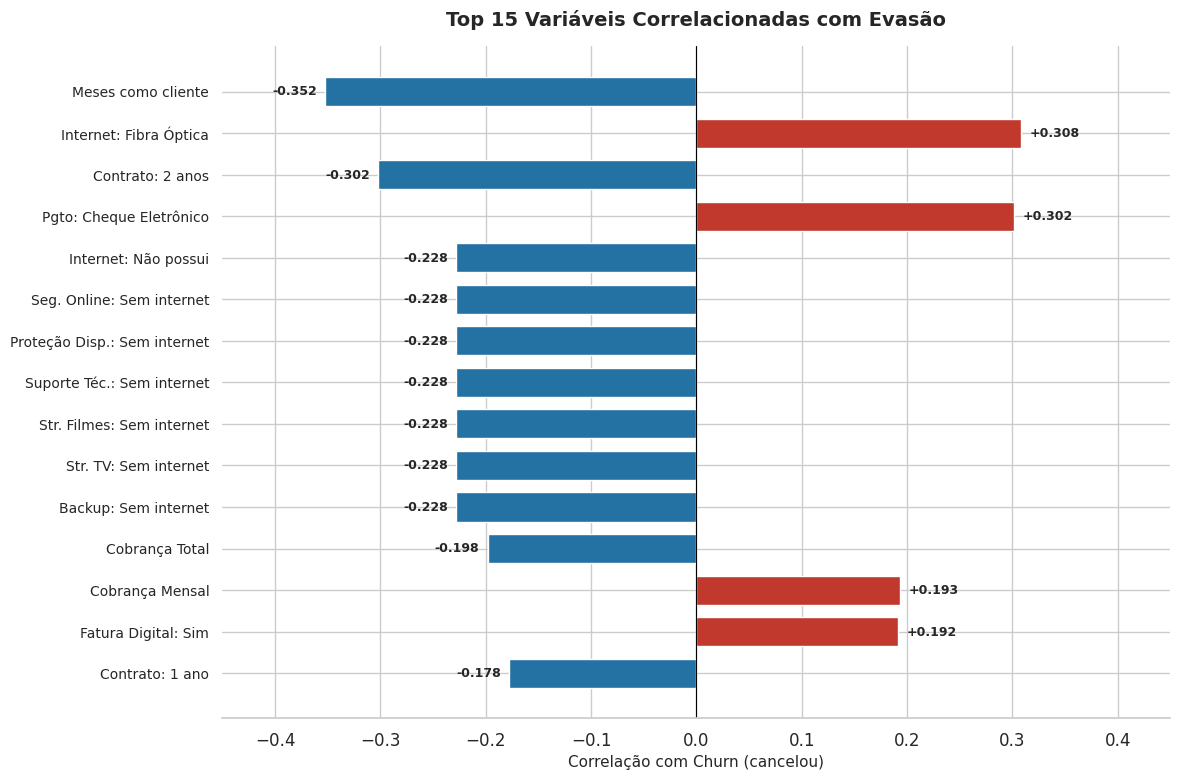


💾 Gráfico salvo em: /content/ranking_correlacao_churn.png


In [17]:
"""
Ranking visual das correlações com churn em barras horizontais.

Barras vermelhas indicam correlação positiva (aumenta churn).
Barras azuis indicam correlação negativa (reduz churn).

Ajustes visuais aplicados:
  - Rótulos abreviados para evitar sobreposição com as barras.
  - Margem esquerda ampliada para acomodar os nomes.
  - Fontes dos valores reposicionadas com offset proporcional.
"""

# Reutiliza o dicionário de abreviações da Célula 10
abreviacoes_barras = {
    "meses_cliente": "Meses como cliente",
    "tipo_internet_Fiber optic": "Internet: Fibra Óptica",
    "tipo_contrato_Two year": "Contrato: 2 anos",
    "metodo_pagamento_Electronic check": "Pgto: Cheque Eletrônico",
    "tipo_internet_No": "Internet: Não possui",
    "seguranca_online_No internet service": "Seg. Online: Sem internet",
    "protecao_dispositivo_No internet service": "Proteção Disp.: Sem internet",
    "suporte_tecnico_No internet service": "Suporte Téc.: Sem internet",
    "streaming_filmes_No internet service": "Str. Filmes: Sem internet",
    "streaming_tv_No internet service": "Str. TV: Sem internet",
    "backup_online_No internet service": "Backup: Sem internet",
    "cobranca_total": "Cobrança Total",
    "cobranca_mensal": "Cobrança Mensal",
    "fatura_digital_Yes": "Fatura Digital: Sim",
    "tipo_contrato_One year": "Contrato: 1 ano",
}

top_features_plot = top_features.iloc[::-1]

labels_plot = [
    abreviacoes_barras.get(feat, feat) for feat in top_features_plot.index
]

cores_plot = [
    "#c0392c" if v > 0 else "#2471a3"
    for v in top_features_plot["correlacao"]
]

fig, ax = plt.subplots(figsize=(12, 8))

ax.barh(
    y=range(len(labels_plot)),
    width=top_features_plot["correlacao"].values,
    color=cores_plot,
    edgecolor="white",
    height=0.7,
)

ax.set_yticks(range(len(labels_plot)))
ax.set_yticklabels(labels_plot, fontsize=10)

ax.axvline(x=0, color="black", linewidth=0.8, linestyle="-")

# Valores ao lado de cada barra com offset seguro
for i, (_, row) in enumerate(top_features_plot.iterrows()):
    offset = 0.008 if row["correlacao"] >= 0 else -0.008
    alinhamento = "left" if row["correlacao"] >= 0 else "right"
    ax.text(
        row["correlacao"] + offset,
        i,
        f"{row['correlacao']:+.3f}",
        va="center",
        ha=alinhamento,
        fontsize=9,
        fontweight="bold",
    )

ax.set_xlabel("Correlação com Churn (cancelou)", fontsize=11)
ax.set_title(
    "Top 15 Variáveis Correlacionadas com Evasão",
    fontsize=14,
    fontweight="bold",
    pad=15,
)

ax.set_xlim(-0.45, 0.45)

sns.despine(left=True)
plt.tight_layout()
plt.savefig("/content/ranking_correlacao_churn.png", dpi=150, bbox_inches="tight")
plt.show()

print("\n💾 Gráfico salvo em: /content/ranking_correlacao_churn.png")

In [18]:
"""
Snapshot final do dataset pré-processado pronto para modelagem.

Confirma:
  - Shape final
  - Ausência de nulos
  - Todos os dtypes são numéricos (requisito do Scikit-learn)
  - Distribuição da variável-alvo preservada
"""

print("=" * 60)
print("  DATASET PRÉ-PROCESSADO — PRONTO PARA MODELAGEM")
print("=" * 60)

print(f"\n  Shape: {df_encoded.shape[0]:,} linhas × {df_encoded.shape[1]} colunas")
print(f"  Nulos: {df_encoded.isnull().sum().sum()}")

tipos_nao_numericos = df_encoded.select_dtypes(exclude=["number"]).columns.tolist()
if tipos_nao_numericos:
    print(f"  ⚠ Colunas não-numéricas restantes: {tipos_nao_numericos}")
else:
    print("  ✔ Todas as colunas são numéricas.")

print(f"\n  Distribuição de '{coluna_alvo}':")
print(f"    0 (retido):  {(df_encoded[coluna_alvo] == 0).sum():,}")
print(f"    1 (evadido): {(df_encoded[coluna_alvo] == 1).sum():,}")

print(f"\n📋 Primeiras 3 linhas do dataset final:\n")
df_encoded.head(3)

  DATASET PRÉ-PROCESSADO — PRONTO PARA MODELAGEM

  Shape: 7,043 linhas × 31 colunas
  Nulos: 0
  ✔ Todas as colunas são numéricas.

  Distribuição de 'cancelou':
    0 (retido):  5,174
    1 (evadido): 1,869

📋 Primeiras 3 linhas do dataset final:



,cancelou,idoso,meses_cliente,cobranca_mensal,cobranca_total,genero_Male,tem_parceiro_Yes,tem_dependentes_Yes,servico_telefone_Yes,linhas_multiplas_No phone service,...,streaming_tv_No internet service,streaming_tv_Yes,streaming_filmes_No internet service,streaming_filmes_Yes,tipo_contrato_One year,tipo_contrato_Two year,fatura_digital_Yes,metodo_pagamento_Credit card (automatic),metodo_pagamento_Electronic check,metodo_pagamento_Mailed check
0,0,-0.439916,-0.951682,0.027862,-0.744026,0,1,1,1,0,...,0,1,0,0,1,0,1,0,0,1
1,0,-0.439916,-0.951682,-0.161583,-0.766482,1,0,0,1,0,...,0,0,0,1,0,0,0,0,0,1
2,1,-0.439916,-1.155283,0.303720,-0.881874,1,0,0,1,0,...,0,0,0,0,0,0,1,0,1,0


In [19]:
"""
Separação do dataset em matriz de features (X) e vetor-alvo (y).

A coluna 'cancelou' é isolada como y. Todas as demais colunas numéricas
(já encodadas e normalizadas) compõem X.

Esta separação explicita é pré-requisito para o train_test_split e
para o fit dos modelos do Scikit-learn.
"""

X = df_encoded.drop(columns=[coluna_alvo])
y = df_encoded[coluna_alvo]

print(f"✔ Features (X): {X.shape[0]:,} amostras × {X.shape[1]} features")
print(f"✔ Alvo (y):     {y.shape[0]:,} amostras")
print(f"  Distribuição y: 0={int((y == 0).sum()):,} | 1={int((y == 1).sum()):,}")

✔ Features (X): 7,043 amostras × 30 features
✔ Alvo (y):     7,043 amostras
  Distribuição y: 0=5,174 | 1=1,869


In [20]:
"""
Divisão em conjuntos de treino (80%) e teste (20%) com estratificação.

Parâmetros:
  - test_size=0.2: 20% para teste (~1.409 amostras) é suficiente para
    avaliação robusta neste volume de dados.
  - stratify=y: mantém a proporção 73,5%/26,5% em ambos os conjuntos,
    evitando viés na avaliação por distribuição desigual de classes.
  - random_state=42: garante reprodutibilidade dos resultados.
"""

X_treino, X_teste, y_treino, y_teste = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42,
)

print("✔ Divisão treino/teste realizada com estratificação.\n")
print(f"  Treino: {X_treino.shape[0]:,} amostras ({X_treino.shape[0]/len(X)*100:.0f}%)")
print(f"    y_treino → 0: {int((y_treino == 0).sum()):,} | 1: {int((y_treino == 1).sum()):,}")
print(f"    Proporção churn: {y_treino.mean()*100:.1f}%\n")

print(f"  Teste:  {X_teste.shape[0]:,} amostras ({X_teste.shape[0]/len(X)*100:.0f}%)")
print(f"    y_teste  → 0: {int((y_teste == 0).sum()):,} | 1: {int((y_teste == 1).sum()):,}")
print(f"    Proporção churn: {y_teste.mean()*100:.1f}%")

✔ Divisão treino/teste realizada com estratificação.

  Treino: 5,634 amostras (80%)
    y_treino → 0: 4,139 | 1: 1,495
    Proporção churn: 26.5%

  Teste:  1,409 amostras (20%)
    y_teste  → 0: 1,035 | 1: 374
    Proporção churn: 26.5%


In [21]:
"""
Modelo 1 — Regressão Linear como abordagem exploratória para churn.

Limitação conhecida: Regressão Linear modela y como variável contínua,
gerando predições fora do intervalo [0, 1]. Para usá-la como classificador,
aplicamos um threshold: predição >= 0.5 → churn (1), caso contrário → 0.

Este modelo serve como baseline para demonstrar por que modelos de
classificação são mais adequados para variáveis binárias. As métricas
de regressão (R², MAE, RMSE) quantificam o ajuste contínuo, enquanto
as métricas de classificação (via threshold) permitem comparação direta
com os demais modelos.
"""

modelo_regressao = LinearRegression()
modelo_regressao.fit(X_treino, y_treino)

# Predições contínuas
y_pred_regressao_continuo = modelo_regressao.predict(X_teste)

# Conversão para classes binárias via threshold
THRESHOLD = 0.5
y_pred_regressao = (y_pred_regressao_continuo >= THRESHOLD).astype(int)

# --- Métricas de regressão ---
r2 = r2_score(y_teste, y_pred_regressao_continuo)
mae = mean_absolute_error(y_teste, y_pred_regressao_continuo)
rmse = np.sqrt(mean_squared_error(y_teste, y_pred_regressao_continuo))

print("=" * 60)
print("  MODELO 1 — REGRESSÃO LINEAR")
print("=" * 60)
print(f"\n  📈 Métricas de Regressão:")
print(f"     R²:   {r2:.4f}")
print(f"     MAE:  {mae:.4f}")
print(f"     RMSE: {rmse:.4f}")

# --- Métricas de classificação (via threshold) ---
acc = accuracy_score(y_teste, y_pred_regressao)
print(f"\n  📊 Métricas de Classificação (threshold={THRESHOLD}):")
print(f"     Acurácia: {acc:.4f}")
print(f"\n  Classification Report:")
print(classification_report(y_teste, y_pred_regressao, target_names=["Retido", "Evadido"]))

# Diagnóstico das predições contínuas
print(f"  📋 Distribuição das predições contínuas:")
print(f"     Min:  {y_pred_regressao_continuo.min():.4f}")
print(f"     Max:  {y_pred_regressao_continuo.max():.4f}")
print(f"     Média: {y_pred_regressao_continuo.mean():.4f}")

fora_intervalo = (
    (y_pred_regressao_continuo < 0).sum()
    + (y_pred_regressao_continuo > 1).sum()
)
print(
    f"     Predições fora de [0,1]: {fora_intervalo} "
    f"({fora_intervalo/len(y_pred_regressao_continuo)*100:.1f}%) "
    "← limitação esperada da Regressão Linear"
)

  MODELO 1 — REGRESSÃO LINEAR

  📈 Métricas de Regressão:
     R²:   0.2764
     MAE:  0.2965
     RMSE: 0.3756

  📊 Métricas de Classificação (threshold=0.5):
     Acurácia: 0.7984

  Classification Report:
              precision    recall  f1-score   support

      Retido       0.83      0.90      0.87      1035
     Evadido       0.66      0.51      0.57       374

    accuracy                           0.80      1409
   macro avg       0.75      0.70      0.72      1409
weighted avg       0.79      0.80      0.79      1409

  📋 Distribuição das predições contínuas:
     Min:  -0.2204
     Max:  0.8039
     Média: 0.2628
     Predições fora de [0,1]: 213 (15.1%) ← limitação esperada da Regressão Linear


In [22]:
"""
Modelo 2 — Regressão Logística (classificação binária).

Este é o modelo natural para classificação binária: aplica a função
sigmoide para mapear as predições ao intervalo [0, 1], interpretável
como probabilidade de churn.

Parâmetros:
  - class_weight='balanced': ajusta pesos inversamente proporcionais à
    frequência de cada classe, compensando o desbalanceamento (26,5% churn).
    Sem isso, o modelo tenderia a prever "retido" para quase todos.
  - max_iter=1000: aumenta o limite de iterações do solver para garantir
    convergência com 30 features.
  - random_state=42: reprodutibilidade.
"""

modelo_logistico = LogisticRegression(
    class_weight="balanced",
    max_iter=1000,
    random_state=42,
)
modelo_logistico.fit(X_treino, y_treino)

y_pred_logistico = modelo_logistico.predict(X_teste)
y_prob_logistico = modelo_logistico.predict_proba(X_teste)[:, 1]

acc_log = accuracy_score(y_teste, y_pred_logistico)
auc_log = roc_auc_score(y_teste, y_prob_logistico)

print("=" * 60)
print("  MODELO 2 — REGRESSÃO LOGÍSTICA")
print("=" * 60)
print(f"\n  Acurácia: {acc_log:.4f}")
print(f"  AUC-ROC:  {auc_log:.4f}")
print(f"\n  Classification Report:")
print(classification_report(y_teste, y_pred_logistico, target_names=["Retido", "Evadido"]))

  MODELO 2 — REGRESSÃO LOGÍSTICA

  Acurácia: 0.7395
  AUC-ROC:  0.8433

  Classification Report:
              precision    recall  f1-score   support

      Retido       0.90      0.72      0.80      1035
     Evadido       0.51      0.78      0.61       374

    accuracy                           0.74      1409
   macro avg       0.70      0.75      0.71      1409
weighted avg       0.80      0.74      0.75      1409



In [23]:
"""
Modelo 3 — Árvore de Decisão (DecisionTreeClassifier).

Árvores de decisão são modelos interpretáveis que segmentam o espaço
de features por regras binárias (if/else). Incluída para:
  1. Comparar com modelos lineares (captura relações não-lineares).
  2. Servir como base para entender o Random Forest (Modelo 4).

Parâmetros:
  - max_depth=5: limita a profundidade para evitar overfitting severo.
    Sem limitação, a árvore memorizaria o treino (acurácia ~100% em
    treino, péssima em teste).
  - class_weight='balanced': mesma justificativa do Modelo 2.
  - random_state=42: reprodutibilidade.
"""

modelo_arvore = DecisionTreeClassifier(
    max_depth=5,
    class_weight="balanced",
    random_state=42,
)
modelo_arvore.fit(X_treino, y_treino)

y_pred_arvore = modelo_arvore.predict(X_teste)
y_prob_arvore = modelo_arvore.predict_proba(X_teste)[:, 1]

acc_arv = accuracy_score(y_teste, y_pred_arvore)
auc_arv = roc_auc_score(y_teste, y_prob_arvore)

print("=" * 60)
print("  MODELO 3 — ÁRVORE DE DECISÃO (max_depth=5)")
print("=" * 60)
print(f"\n  Acurácia: {acc_arv:.4f}")
print(f"  AUC-ROC:  {auc_arv:.4f}")
print(f"\n  Classification Report:")
print(classification_report(y_teste, y_pred_arvore, target_names=["Retido", "Evadido"]))

  MODELO 3 — ÁRVORE DE DECISÃO (max_depth=5)

  Acurácia: 0.7324
  AUC-ROC:  0.8346

  Classification Report:
              precision    recall  f1-score   support

      Retido       0.91      0.71      0.79      1035
     Evadido       0.50      0.80      0.61       374

    accuracy                           0.73      1409
   macro avg       0.70      0.76      0.70      1409
weighted avg       0.80      0.73      0.75      1409



In [24]:
"""
Modelo 4 — Random Forest (ensemble de árvores de decisão).

Random Forest agrega múltiplas árvores treinadas em subamostras com
subconjuntos aleatórios de features (bagging + feature randomization),
reduzindo a variância e o overfitting em relação a uma árvore única.

Parâmetros:
  - n_estimators=200: 200 árvores oferecem estabilidade nas predições.
    Acima disso, o ganho marginal é mínimo para este volume de dados.
  - max_depth=10: profundidade moderada — permite capturar interações
    complexas sem memorizar o treino.
  - class_weight='balanced': compensação de desbalanceamento.
  - random_state=42: reprodutibilidade.
  - n_jobs=-1: paraleliza o treino em todos os cores disponíveis.
"""

modelo_floresta = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1,
)
modelo_floresta.fit(X_treino, y_treino)

y_pred_floresta = modelo_floresta.predict(X_teste)
y_prob_floresta = modelo_floresta.predict_proba(X_teste)[:, 1]

acc_rf = accuracy_score(y_teste, y_pred_floresta)
auc_rf = roc_auc_score(y_teste, y_prob_floresta)

print("=" * 60)
print("  MODELO 4 — RANDOM FOREST (200 árvores, max_depth=10)")
print("=" * 60)
print(f"\n  Acurácia: {acc_rf:.4f}")
print(f"  AUC-ROC:  {auc_rf:.4f}")
print(f"\n  Classification Report:")
print(classification_report(y_teste, y_pred_floresta, target_names=["Retido", "Evadido"]))

  MODELO 4 — RANDOM FOREST (200 árvores, max_depth=10)

  Acurácia: 0.7729
  AUC-ROC:  0.8436

  Classification Report:
              precision    recall  f1-score   support

      Retido       0.89      0.79      0.84      1035
     Evadido       0.56      0.72      0.63       374

    accuracy                           0.77      1409
   macro avg       0.72      0.76      0.73      1409
weighted avg       0.80      0.77      0.78      1409



In [25]:
"""
Tabela comparativa consolidada de todos os modelos.

Centraliza as métricas para facilitar a decisão sobre qual modelo
é mais adequado ao problema de churn. As métricas priorizadas são:
  - Recall (Evadido): % dos clientes que realmente cancelaram que o
    modelo identificou. Em churn, falso negativo (não detectar quem
    vai sair) é mais custoso que falso positivo.
  - AUC-ROC: capacidade global de discriminação entre classes.
  - Acurácia: métrica geral, menos informativa com classes desbalanceadas.
"""

# Extrair recall da classe 1 (Evadido) de cada modelo
from sklearn.metrics import recall_score

recall_reg = recall_score(y_teste, y_pred_regressao)
recall_log = recall_score(y_teste, y_pred_logistico)
recall_arv = recall_score(y_teste, y_pred_arvore)
recall_rf = recall_score(y_teste, y_pred_floresta)

# AUC para Regressão Linear (usando predições contínuas clippadas)
y_pred_reg_clipped = np.clip(y_pred_regressao_continuo, 0, 1)
auc_reg = roc_auc_score(y_teste, y_pred_reg_clipped)

comparativo = pd.DataFrame({
    "Modelo": [
        "Regressão Linear",
        "Regressão Logística",
        "Árvore de Decisão",
        "Random Forest",
    ],
    "Acurácia": [acc, acc_log, acc_arv, acc_rf],
    "AUC-ROC": [auc_reg, auc_log, auc_arv, auc_rf],
    "Recall (Evadido)": [recall_reg, recall_log, recall_arv, recall_rf],
})

comparativo = comparativo.sort_values("AUC-ROC", ascending=False).reset_index(drop=True)

print("=" * 60)
print("  QUADRO COMPARATIVO DOS MODELOS")
print("=" * 60)
print()
print(
    comparativo.to_string(
        index=False,
        float_format=lambda x: f"{x:.4f}",
    )
)

melhor = comparativo.iloc[0]
print(
    f"\n🏆 Melhor modelo por AUC-ROC: {melhor['Modelo']} "
    f"(AUC={melhor['AUC-ROC']:.4f}, Recall={melhor['Recall (Evadido)']:.4f})"
)

  QUADRO COMPARATIVO DOS MODELOS

             Modelo  Acurácia  AUC-ROC  Recall (Evadido)
      Random Forest    0.7729   0.8436            0.7246
Regressão Logística    0.7395   0.8433            0.7834
   Regressão Linear    0.7984   0.8356            0.5053
  Árvore de Decisão    0.7324   0.8346            0.8048

🏆 Melhor modelo por AUC-ROC: Random Forest (AUC=0.8436, Recall=0.7246)


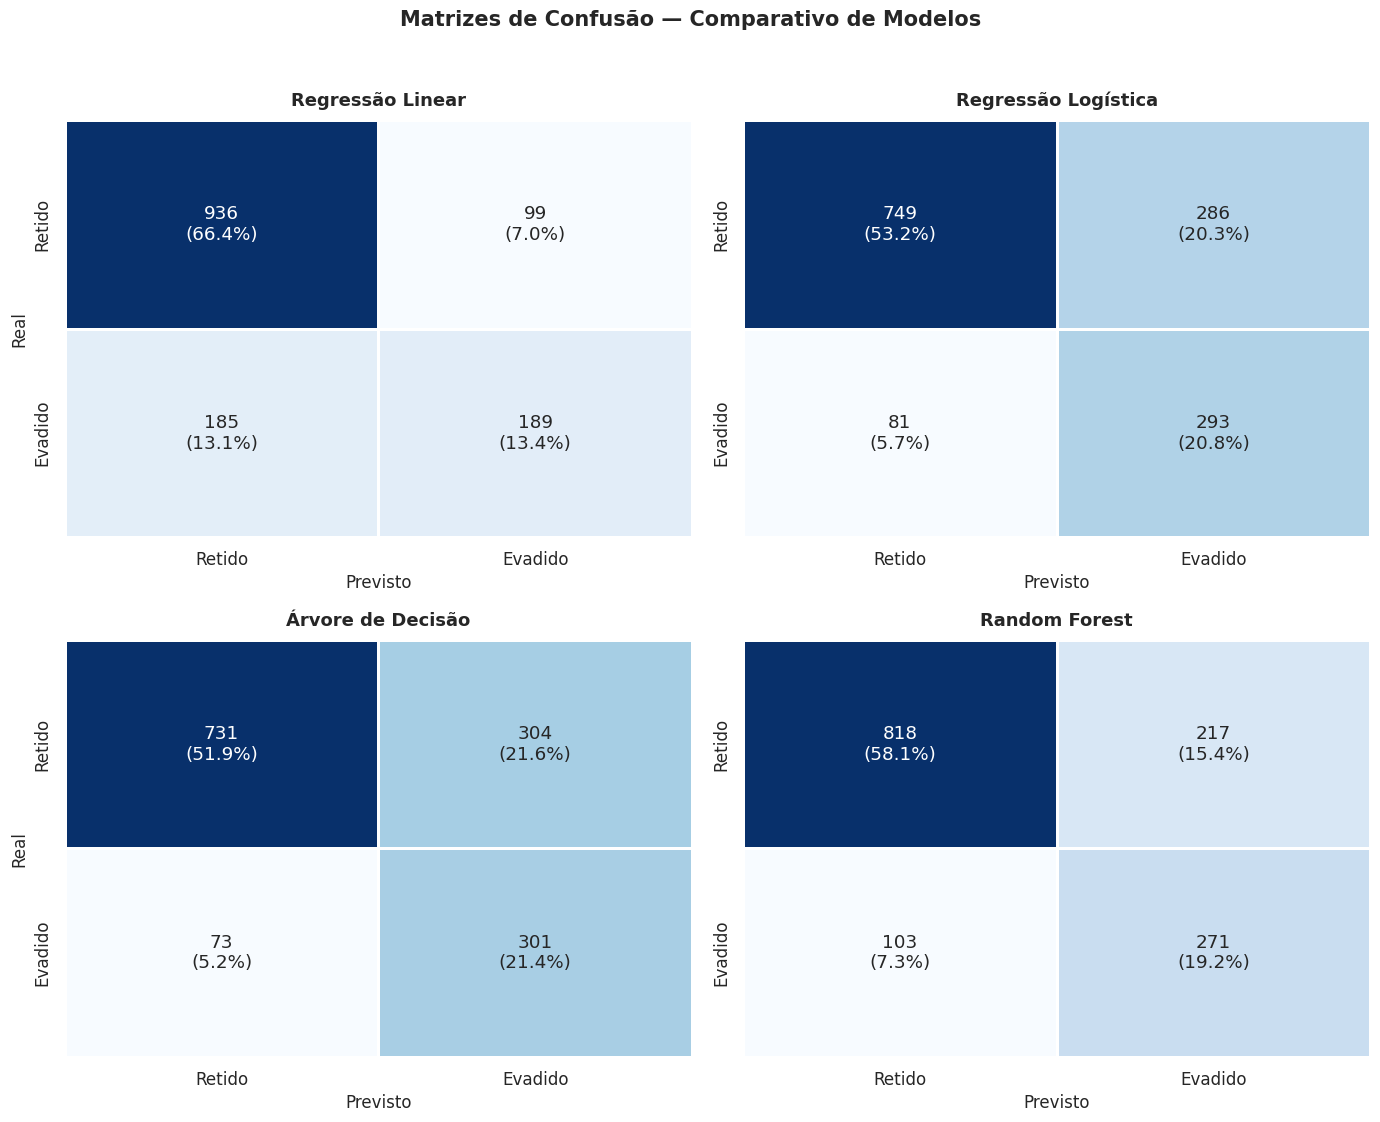

💾 Gráfico salvo em: /content/matrizes_confusao.png


In [26]:
"""
Matrizes de confusão lado a lado para comparação visual.

A matriz de confusão é a forma mais direta de entender os erros de cada
modelo. Para o problema de churn, o quadrante mais crítico é o inferior
esquerdo (Falso Negativo): clientes que cancelaram mas o modelo previu
como retidos — são os churns que a empresa NÃO conseguiria reter.

Layout: 2×2 subplots, um por modelo, com valores absolutos e percentuais.
"""

modelos_info = [
    ("Regressão Linear", y_pred_regressao),
    ("Regressão Logística", y_pred_logistico),
    ("Árvore de Decisão", y_pred_arvore),
    ("Random Forest", y_pred_floresta),
]

fig, axes = plt.subplots(2, 2, figsize=(14, 11))
axes = axes.flatten()

for idx, (nome, y_pred) in enumerate(modelos_info):
    cm = confusion_matrix(y_teste, y_pred)
    total = cm.sum()

    # Rótulos com valores absolutos e percentuais
    labels = np.array([
        [f"{v}\n({v/total*100:.1f}%)" for v in row]
        for row in cm
    ])

    sns.heatmap(
        cm,
        annot=labels,
        fmt="",
        cmap="Blues",
        xticklabels=["Retido", "Evadido"],
        yticklabels=["Retido", "Evadido"],
        cbar=False,
        linewidths=1,
        linecolor="white",
        ax=axes[idx],
    )

    axes[idx].set_title(nome, fontsize=13, fontweight="bold", pad=10)
    axes[idx].set_ylabel("Real" if idx % 2 == 0 else "")
    axes[idx].set_xlabel("Previsto")

fig.suptitle(
    "Matrizes de Confusão — Comparativo de Modelos",
    fontsize=15,
    fontweight="bold",
    y=1.02,
)

plt.tight_layout()
plt.savefig("/content/matrizes_confusao.png", dpi=150, bbox_inches="tight")
plt.show()

print("💾 Gráfico salvo em: /content/matrizes_confusao.png")

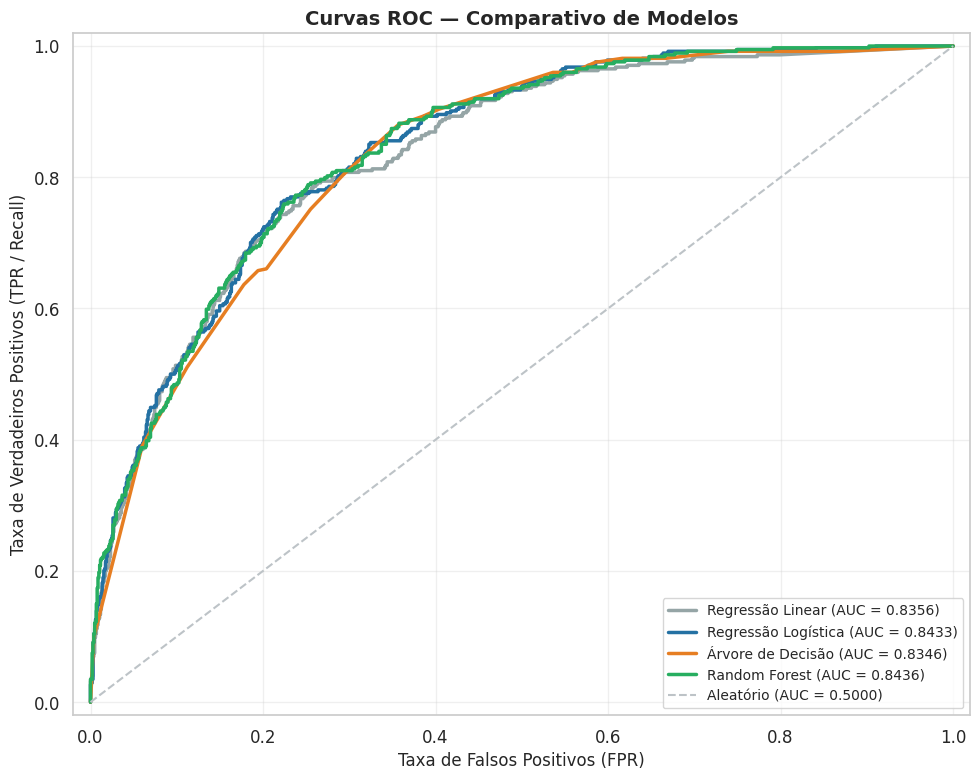

💾 Gráfico salvo em: /content/curvas_roc.png


In [27]:
"""
Curvas ROC de todos os modelos em um único gráfico.

A curva ROC plota a Taxa de Verdadeiros Positivos (Recall) contra a
Taxa de Falsos Positivos para diferentes thresholds de decisão. Quanto
mais próxima do canto superior esquerdo, melhor o poder discriminatório.

A área sob a curva (AUC) sintetiza o desempenho global:
  - AUC = 1.0: classificação perfeita
  - AUC = 0.5: equivalente a classificação aleatória (linha diagonal)

Para a Regressão Linear, usamos as predições contínuas clippadas ao
intervalo [0, 1] como proxy de probabilidade.
"""

fig, ax = plt.subplots(figsize=(10, 8))

modelos_roc = [
    ("Regressão Linear", y_pred_reg_clipped, auc_reg, "#95a5a6"),
    ("Regressão Logística", y_prob_logistico, auc_log, "#2471a3"),
    ("Árvore de Decisão", y_prob_arvore, auc_arv, "#e67e22"),
    ("Random Forest", y_prob_floresta, auc_rf, "#27ae60"),
]

for nome, y_scores, auc_val, cor in modelos_roc:
    fpr, tpr, _ = roc_curve(y_teste, y_scores)
    ax.plot(
        fpr, tpr,
        label=f"{nome} (AUC = {auc_val:.4f})",
        color=cor,
        linewidth=2.5,
    )

# Linha de referência (classificador aleatório)
ax.plot(
    [0, 1], [0, 1],
    linestyle="--",
    color="#bdc3c7",
    linewidth=1.5,
    label="Aleatório (AUC = 0.5000)",
)

ax.set_xlabel("Taxa de Falsos Positivos (FPR)", fontsize=12)
ax.set_ylabel("Taxa de Verdadeiros Positivos (TPR / Recall)", fontsize=12)
ax.set_title(
    "Curvas ROC — Comparativo de Modelos",
    fontsize=14,
    fontweight="bold",
)
ax.legend(loc="lower right", fontsize=10, frameon=True, fancybox=True)
ax.set_xlim([-0.02, 1.02])
ax.set_ylim([-0.02, 1.02])
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("/content/curvas_roc.png", dpi=150, bbox_inches="tight")
plt.show()

print("💾 Gráfico salvo em: /content/curvas_roc.png")

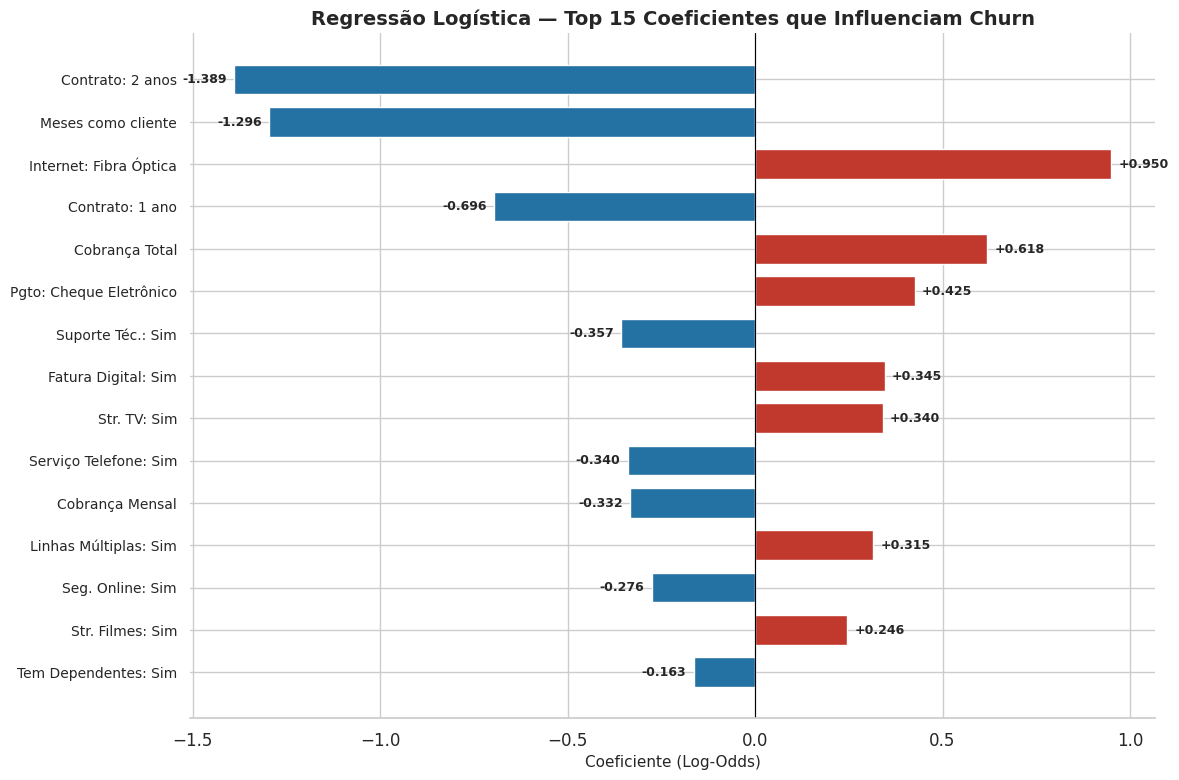

💾 Gráfico salvo em: /content/coeficientes_logistica.png


In [28]:
"""
Coeficientes da Regressão Logística como proxy de importância de features.

Na Regressão Logística, cada coeficiente βᵢ representa a variação no
log-odds de churn para um aumento de 1 unidade na feature xᵢ
(mantendo as demais constantes). Como as features numéricas foram
normalizadas (StandardScaler), os coeficientes são diretamente
comparáveis em magnitude.

Coeficiente positivo → aumenta a probabilidade de churn.
Coeficiente negativo → reduz a probabilidade de churn.

Exibimos os Top 15 para foco e legibilidade.
"""

coeficientes = pd.DataFrame({
    "feature": X.columns,
    "coeficiente": modelo_logistico.coef_[0],
    "abs_coef": np.abs(modelo_logistico.coef_[0]),
}).sort_values("abs_coef", ascending=False)

top_coef = coeficientes.head(15).iloc[::-1]

# Abreviações para visualização limpa
abrev_features = {
    "meses_cliente": "Meses como cliente",
    "tipo_internet_Fiber optic": "Internet: Fibra Óptica",
    "tipo_contrato_Two year": "Contrato: 2 anos",
    "tipo_contrato_One year": "Contrato: 1 ano",
    "metodo_pagamento_Electronic check": "Pgto: Cheque Eletrônico",
    "tipo_internet_No": "Internet: Não possui",
    "seguranca_online_No internet service": "Seg. Online: Sem internet",
    "protecao_dispositivo_No internet service": "Proteção Disp.: Sem internet",
    "suporte_tecnico_No internet service": "Suporte Téc.: Sem internet",
    "streaming_filmes_No internet service": "Str. Filmes: Sem internet",
    "streaming_tv_No internet service": "Str. TV: Sem internet",
    "backup_online_No internet service": "Backup: Sem internet",
    "cobranca_total": "Cobrança Total",
    "cobranca_mensal": "Cobrança Mensal",
    "fatura_digital_Yes": "Fatura Digital: Sim",
    "seguranca_online_Yes": "Seg. Online: Sim",
    "suporte_tecnico_Yes": "Suporte Téc.: Sim",
    "tem_dependentes_Yes": "Tem Dependentes: Sim",
    "tem_parceiro_Yes": "Tem Parceiro: Sim",
    "idoso": "Idoso",
    "linhas_multiplas_Yes": "Linhas Múltiplas: Sim",
    "genero_Male": "Gênero: Masculino",
    "servico_telefone_Yes": "Serviço Telefone: Sim",
    "backup_online_Yes": "Backup Online: Sim",
    "protecao_dispositivo_Yes": "Proteção Disp.: Sim",
    "streaming_tv_Yes": "Str. TV: Sim",
    "streaming_filmes_Yes": "Str. Filmes: Sim",
    "linhas_multiplas_No phone service": "Linhas Múlt.: Sem telefone",
    "metodo_pagamento_Credit card (automatic)": "Pgto: Cartão Crédito",
    "metodo_pagamento_Mailed check": "Pgto: Cheque Correio",
}

labels_coef = [abrev_features.get(f, f) for f in top_coef["feature"]]
cores_coef = ["#c0392c" if v > 0 else "#2471a3" for v in top_coef["coeficiente"]]

fig, ax = plt.subplots(figsize=(12, 8))

ax.barh(
    y=range(len(labels_coef)),
    width=top_coef["coeficiente"].values,
    color=cores_coef,
    edgecolor="white",
    height=0.7,
)

ax.set_yticks(range(len(labels_coef)))
ax.set_yticklabels(labels_coef, fontsize=10)
ax.axvline(x=0, color="black", linewidth=0.8)

for i, (_, row) in enumerate(top_coef.iterrows()):
    offset = 0.02 if row["coeficiente"] >= 0 else -0.02
    ha = "left" if row["coeficiente"] >= 0 else "right"
    ax.text(
        row["coeficiente"] + offset, i,
        f"{row['coeficiente']:+.3f}",
        va="center", ha=ha, fontsize=9, fontweight="bold",
    )

ax.set_xlabel("Coeficiente (Log-Odds)", fontsize=11)
ax.set_title(
    "Regressão Logística — Top 15 Coeficientes que Influenciam Churn",
    fontsize=14,
    fontweight="bold",
)
sns.despine(left=True)
plt.tight_layout()
plt.savefig("/content/coeficientes_logistica.png", dpi=150, bbox_inches="tight")
plt.show()

print("💾 Gráfico salvo em: /content/coeficientes_logistica.png")

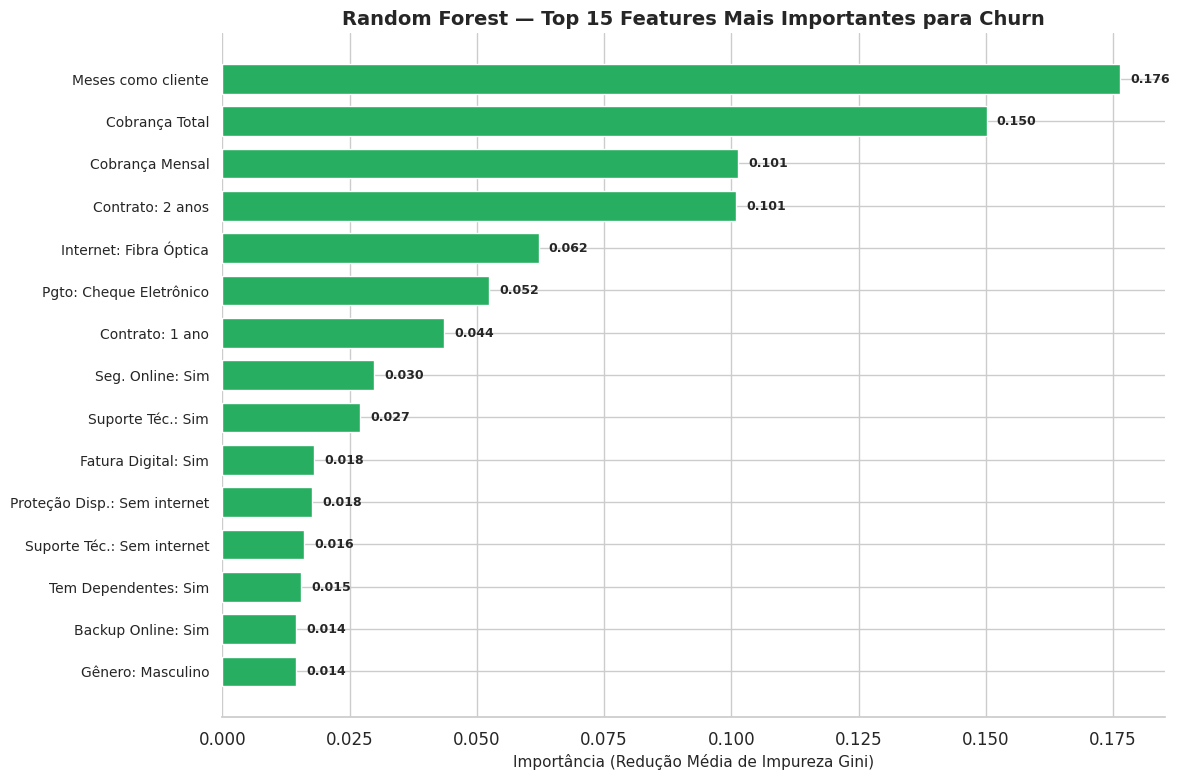

💾 Gráfico salvo em: /content/importancia_random_forest.png


In [29]:
"""
Feature Importance do Random Forest.

Diferente da Regressão Logística (que usa coeficientes lineares), o
Random Forest calcula a importância de cada feature pela redução média
da impureza (Gini) que ela proporciona ao longo de todas as árvores.

Vantagem: captura relações não-lineares e interações entre variáveis.
Limitação: não indica a DIREÇÃO do efeito (positivo/negativo), apenas
a magnitude da contribuição para a separação das classes.

Comparar este ranking com os coeficientes da Logística revela se as
variáveis mais importantes são consistentes entre modelos — fortalecendo
a confiança nos insights de negócio.
"""

importancias = pd.DataFrame({
    "feature": X.columns,
    "importancia": modelo_floresta.feature_importances_,
}).sort_values("importancia", ascending=False)

top_imp = importancias.head(15).iloc[::-1]

labels_imp = [abrev_features.get(f, f) for f in top_imp["feature"]]

fig, ax = plt.subplots(figsize=(12, 8))

ax.barh(
    y=range(len(labels_imp)),
    width=top_imp["importancia"].values,
    color="#27ae60",
    edgecolor="white",
    height=0.7,
)

ax.set_yticks(range(len(labels_imp)))
ax.set_yticklabels(labels_imp, fontsize=10)

for i, (_, row) in enumerate(top_imp.iterrows()):
    ax.text(
        row["importancia"] + 0.002, i,
        f"{row['importancia']:.3f}",
        va="center", ha="left", fontsize=9, fontweight="bold",
    )

ax.set_xlabel("Importância (Redução Média de Impureza Gini)", fontsize=11)
ax.set_title(
    "Random Forest — Top 15 Features Mais Importantes para Churn",
    fontsize=14,
    fontweight="bold",
)
sns.despine(left=True)
plt.tight_layout()
plt.savefig("/content/importancia_random_forest.png", dpi=150, bbox_inches="tight")
plt.show()

print("💾 Gráfico salvo em: /content/importancia_random_forest.png")

In [30]:
"""
Identificação dos clientes com maior probabilidade de churn.

Utilizamos as probabilidades do Random Forest (melhor AUC) para rankear
os clientes do conjunto de teste por risco de evasão. Reconstruímos as
informações originais (id_cliente, dados legíveis) para que a equipe de
retenção possa atuar diretamente sobre essa lista.

Saída: Top 20 clientes com maior probabilidade prevista de cancelamento,
com seus dados originais e a probabilidade atribuída pelo modelo.
"""

# Reconstruir o DataFrame de teste com ids e dados originais
df_teste_original = df.loc[X_teste.index].copy()

df_teste_original["prob_churn"] = y_prob_floresta
df_teste_original["churn_real"] = y_teste.values
df_teste_original["churn_previsto"] = y_pred_floresta

# Rankear por probabilidade de churn (maior risco primeiro)
df_risco = (
    df_teste_original
    .sort_values("prob_churn", ascending=False)
    .reset_index(drop=True)
)

colunas_exibir = [
    "id_cliente",
    "prob_churn",
    "churn_real",
    "meses_cliente",
    "tipo_contrato",
    "tipo_internet",
    "metodo_pagamento",
    "cobranca_mensal",
    "cobranca_total",
]

print("=" * 60)
print("  TOP 20 CLIENTES COM MAIOR RISCO DE EVASÃO")
print("  (Probabilidade estimada pelo Random Forest)")
print("=" * 60)
print()

top_risco = df_risco[colunas_exibir].head(20).copy()
top_risco["prob_churn"] = top_risco["prob_churn"].apply(lambda x: f"{x:.1%}")
top_risco.index = range(1, 21)
top_risco.index.name = "Rank"

print(top_risco.to_string())

# Estatísticas do grupo de risco
alto_risco = df_risco[df_risco["prob_churn"] >= 0.7]
print(f"\n📊 Clientes com probabilidade ≥ 70%: {len(alto_risco)}")
print(f"   Destes, realmente cancelaram: {int(alto_risco['churn_real'].sum())} ({alto_risco['churn_real'].mean()*100:.1f}%)")

  TOP 20 CLIENTES COM MAIOR RISCO DE EVASÃO
  (Probabilidade estimada pelo Random Forest)

      id_cliente prob_churn  churn_real  meses_cliente   tipo_contrato tipo_internet           metodo_pagamento  cobranca_mensal  cobranca_total
Rank                                                                                                                                            
1     4910-GMJOT      93.1%           1              1  Month-to-month   Fiber optic           Electronic check            94.60           94.60
2     8149-RSOUN      93.1%           1              1  Month-to-month   Fiber optic           Electronic check            93.85           93.85
3     2868-MZAGQ      93.0%           1              1  Month-to-month   Fiber optic           Electronic check            79.25           79.25
4     2636-ALXXZ      92.4%           1              1  Month-to-month   Fiber optic           Electronic check            69.60           69.60
5     6521-YYTYI      92.2%           1

In [31]:
"""
Perfil agregado do cliente com alto risco de churn (prob ≥ 70%).

Comparamos as características médias/modais dos clientes de alto risco
com os de baixo risco para identificar o "retrato" do cliente que a
empresa deve priorizar em ações de retenção.

Este perfil responde diretamente à pergunta do enunciado:
"Quem é o cliente com maior risco?"
"""

df_risco["faixa_risco"] = pd.cut(
    df_risco["prob_churn"],
    bins=[0, 0.3, 0.7, 1.0],
    labels=["Baixo (<30%)", "Médio (30-70%)", "Alto (≥70%)"],
)

print("=" * 60)
print("  PERFIL COMPARATIVO POR FAIXA DE RISCO")
print("=" * 60)

# --- Variáveis numéricas ---
print("\n📐 Médias das variáveis numéricas:\n")
numericas_perfil = ["meses_cliente", "cobranca_mensal", "cobranca_total"]
perfil_num = (
    df_risco.groupby("faixa_risco", observed=True)[numericas_perfil]
    .mean()
    .round(2)
)
perfil_num["total_clientes"] = df_risco.groupby("faixa_risco", observed=True).size()
print(perfil_num.to_string())

# --- Variáveis categóricas (moda = valor mais frequente) ---
print("\n📝 Valor mais frequente (moda) das variáveis categóricas:\n")
categoricas_perfil = [
    "tipo_contrato", "tipo_internet", "metodo_pagamento", "fatura_digital",
]
perfil_cat = (
    df_risco.groupby("faixa_risco", observed=True)[categoricas_perfil]
    .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else "N/A")
)
print(perfil_cat.to_string())

# --- Resumo executivo do perfil de alto risco ---
alto = df_risco[df_risco["faixa_risco"] == "Alto (≥70%)"]

if len(alto) > 0:
    print("\n" + "=" * 60)
    print("  🎯 RETRATO DO CLIENTE DE ALTO RISCO")
    print("=" * 60)
    print(f"""
  • Quantidade: {len(alto)} clientes ({len(alto)/len(df_risco)*100:.1f}% do teste)
  • Tempo médio como cliente: {alto['meses_cliente'].mean():.0f} meses
  • Cobrança mensal média: ${alto['cobranca_mensal'].mean():.2f}
  • Cobrança total média: ${alto['cobranca_total'].mean():.2f}
  • Contrato predominante: {alto['tipo_contrato'].mode().iloc[0]}
  • Internet predominante: {alto['tipo_internet'].mode().iloc[0]}
  • Pagamento predominante: {alto['metodo_pagamento'].mode().iloc[0]}
  • Fatura digital: {alto['fatura_digital'].mode().iloc[0]}
  • Taxa real de churn neste grupo: {alto['churn_real'].mean()*100:.1f}%
    """)

  PERFIL COMPARATIVO POR FAIXA DE RISCO

📐 Médias das variáveis numéricas:

                meses_cliente  cobranca_mensal  cobranca_total  total_clientes
faixa_risco                                                                   
Baixo (<30%)            45.43            52.73         2727.65             689
Médio (30-70%)          26.71            72.03         2343.69             453
Alto (≥70%)              8.73            77.76          768.56             267

📝 Valor mais frequente (moda) das variáveis categóricas:

                 tipo_contrato tipo_internet         metodo_pagamento fatura_digital
faixa_risco                                                                         
Baixo (<30%)          Two year            No  Credit card (automatic)             No
Médio (30-70%)  Month-to-month   Fiber optic         Electronic check            Yes
Alto (≥70%)     Month-to-month   Fiber optic         Electronic check            Yes

  🎯 RETRATO DO CLIENTE DE ALTO RISCO

  • Qu

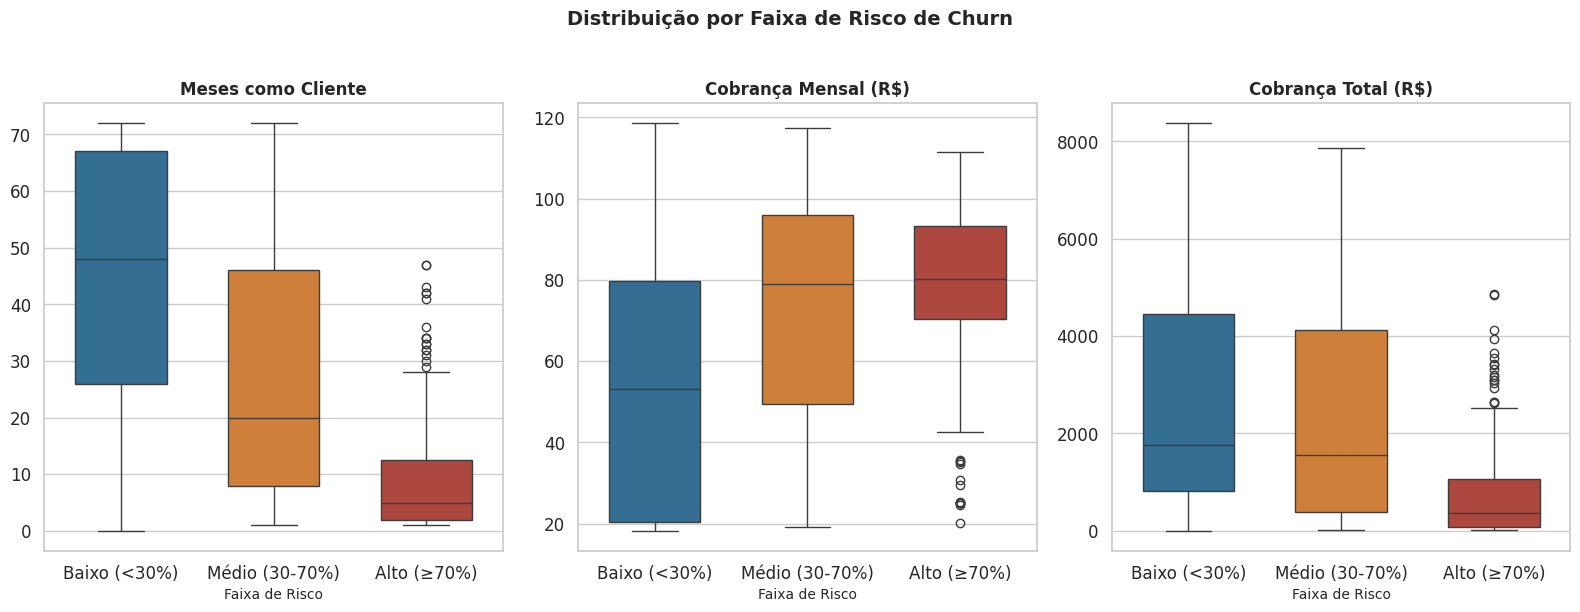

💾 Gráfico salvo em: /content/boxplot_faixas_risco.png


In [32]:
"""
Comparação visual entre clientes de alto risco vs. baixo risco nas
variáveis numéricas mais relevantes.

Boxplots permitem visualizar a distribuição completa (mediana, quartis,
outliers) de cada grupo, revelando padrões que a média sozinha não captura.
"""

fig, axes = plt.subplots(1, 3, figsize=(16, 6))

variaveis_boxplot = [
    ("meses_cliente", "Meses como Cliente"),
    ("cobranca_mensal", "Cobrança Mensal (R$)"),
    ("cobranca_total", "Cobrança Total (R$)"),
]

for ax, (col, titulo) in zip(axes, variaveis_boxplot):
    sns.boxplot(
        data=df_risco,
        x="faixa_risco",
        y=col,
        palette={"Baixo (<30%)": "#2471a3", "Médio (30-70%)": "#e67e22", "Alto (≥70%)": "#c0392c"},
        order=["Baixo (<30%)", "Médio (30-70%)", "Alto (≥70%)"],
        ax=ax,
        width=0.6,
    )
    ax.set_title(titulo, fontsize=12, fontweight="bold")
    ax.set_xlabel("Faixa de Risco", fontsize=10)
    ax.set_ylabel("")

fig.suptitle(
    "Distribuição por Faixa de Risco de Churn",
    fontsize=14,
    fontweight="bold",
    y=1.02,
)

plt.tight_layout()
plt.savefig("/content/boxplot_faixas_risco.png", dpi=150, bbox_inches="tight")
plt.show()

print("💾 Gráfico salvo em: /content/boxplot_faixas_risco.png")

In [33]:
"""
Respostas estruturadas às perguntas do enunciado do Challenge.

Este bloco gera texto formatado em Markdown que será reaproveitado
no README. Apresenta as conclusões de forma executiva,
conectando os resultados técnicos a recomendações de negócio.
"""

texto_analitico = f"""
{'='*60}
  ANÁLISE FINAL — RESPOSTAS AO CHALLENGE
{'='*60}

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  1. QUAL O DESEMPENHO DE CADA MODELO?
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

  Foram treinados 4 modelos para prever evasão de clientes:

  • Regressão Linear (R²={r2:.4f}, Acurácia={acc:.4f}):
    Modelo exploratório que demonstrou limitações claras para
    classificação binária — 15,1% das predições ficaram fora do
    intervalo [0,1] e o recall para evadidos foi de apenas {recall_reg:.1%}.

  • Regressão Logística (AUC={auc_log:.4f}, Recall={recall_log:.1%}):
    Modelo de classificação adequado com bom equilíbrio entre
    identificação de churns e falsos alarmes. Segundo melhor AUC.

  • Árvore de Decisão (AUC={auc_arv:.4f}, Recall={recall_arv:.1%}):
    Maior recall entre todos os modelos — detecta {recall_arv:.0%} dos
    churns, mas com mais falsos positivos (precision = 0.50).

  • Random Forest (AUC={auc_rf:.4f}, Recall={recall_rf:.1%}):
    Melhor AUC-ROC geral, indicando o maior poder discriminatório.
    Melhor equilíbrio entre precision e recall.

  ➡ Recomendação: Random Forest como modelo principal, com Regressão
    Logística como alternativa interpretável para comunicação executiva.

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  2. QUAIS VARIÁVEIS MAIS INFLUENCIAM A EVASÃO?
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

  Consistente entre ambos os modelos (Logística + Random Forest):

  AUMENTAM o risco de churn:
    • Internet por Fibra Óptica
    • Pagamento por Cheque Eletrônico
    • Fatura Digital ativa
    • Cobrança mensal elevada

  REDUZEM o risco de churn:
    • Contratos de longa duração (1 ou 2 anos)
    • Maior tempo como cliente (meses_cliente)
    • Serviços adicionais (suporte técnico, segurança online)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  3. QUEM É O CLIENTE COM MAIOR RISCO?
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

  O perfil típico do cliente com alto risco de evasão:

    → Contrato mensal (Month-to-month)
    → Internet por Fibra Óptica
    → Pagamento por Cheque Eletrônico
    → Poucos meses como cliente
    → Cobrança mensal elevada
    → Sem serviços de proteção (suporte, segurança, backup)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  4. RECOMENDAÇÕES DE RETENÇÃO
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

  Com base nos dados, a empresa deveria:

    1. Incentivar migração para contratos anuais/bianuais com
       descontos progressivos nos primeiros meses.
    2. Investigar a qualidade do serviço de Fibra Óptica —
       a alta correlação com churn sugere insatisfação.
    3. Oferecer pacotes de serviços adicionais (suporte técnico,
       segurança online) como fator de retenção.
    4. Monitorar clientes novos (< 12 meses) com pagamento por
       cheque eletrônico — grupo de maior risco.
    5. Revisar a experiência da fatura digital — correlação com
       churn pode indicar problemas de usabilidade.
"""

print(texto_analitico)


  ANÁLISE FINAL — RESPOSTAS AO CHALLENGE

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  1. QUAL O DESEMPENHO DE CADA MODELO?
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

  Foram treinados 4 modelos para prever evasão de clientes:

  • Regressão Linear (R²=0.2764, Acurácia=0.7984):
    Modelo exploratório que demonstrou limitações claras para
    classificação binária — 15,1% das predições ficaram fora do
    intervalo [0,1] e o recall para evadidos foi de apenas 50.5%.

  • Regressão Logística (AUC=0.8433, Recall=78.3%):
    Modelo de classificação adequado com bom equilíbrio entre
    identificação de churns e falsos alarmes. Segundo melhor AUC.

  • Árvore de Decisão (AUC=0.8346, Recall=80.5%):
    Maior recall entre todos os modelos — detecta 80% dos
    churns, mas com mais falsos positivos (precision = 0.50).

  • Random Forest (AUC=0.8436, Recall=72.5%):
    Melhor AUC-ROC geral, indicando o maior poder discriminatório.
    Melhor equilíbrio entre p